# Dense Net 201

In [ ]:
# 🔹 System & Utils
import random
import gdown

# 🔹 Data Handling
import numpy as np
import pandas as pd

# 🔹 Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 🔹 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 TensorFlow Core
import tensorflow as tf

# 🔹 Keras Applications & Layers
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# 🔹 Training Utils
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# 🔹 MLflow Tracking
from utils.MLFlowTrackingConfig import MLFlowTracking


In [ ]:
# load the dataset

data = np.load('../artifacts/data_ingestion/Preprocessed Dataset/train_data.npz')

# input data
X = data['arr_0']

# output 
y = data['arr_1']

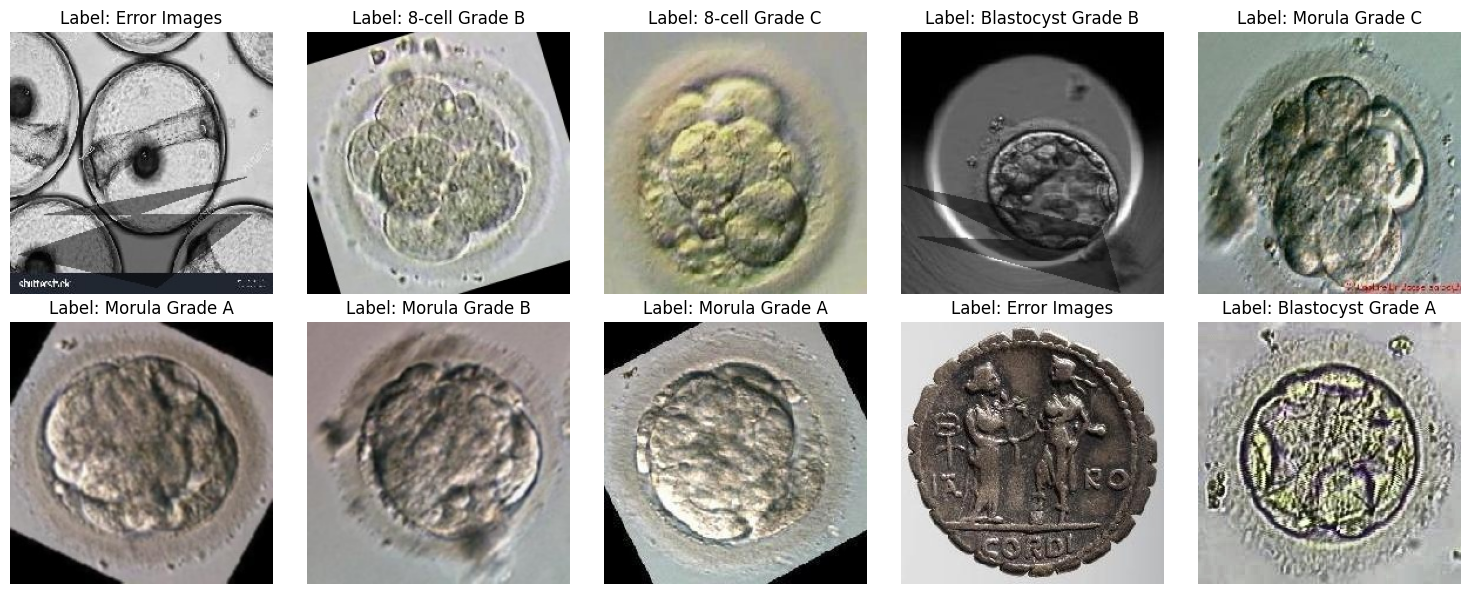

In [ ]:
# randomly show 10 images with labels 

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random.sample(range(len(X)), 10)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].astype('uint8'))
    plt.title(f"Label: {y[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# shape

X.shape

(8621, 224, 224, 3)

In [10]:
# labels counts

pd.Series(y).value_counts()

Morula Grade C        900
Morula Grade B        900
Morula Grade A        900
Error Images          899
Blastocyst Grade C    893
Blastocyst Grade B    881
Blastocyst Grade A    876
8-cell Grade A        802
8-cell Grade C        796
8-cell Grade B        774
Name: count, dtype: int64

In [13]:
# now handel the labels

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(y)

# matrix
labels = to_categorical(y_encoded, len(label_encoder.classes_))

In [14]:
# show the first five labels

labels[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [15]:
# train and test split 

x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size= 0.1, random_state=42, stratify = labels)

In [16]:
# check the shape -> train

x_train.shape, y_train.shape

((7758, 224, 224, 3), (7758, 10))

In [17]:
# check the shape -> test

x_test.shape, y_test.shape

((863, 224, 224, 3), (863, 10))

In [18]:
# Model

# image size
input_shape = (224, 224, 3)  

# base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model
base_model.trainable = False

I0000 00:00:1745309170.483613      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745309170.484304      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# 🔹 Custom head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)

In [22]:
# 🔹 Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# 🔹 Callbacks

# early stop
early_stop = EarlyStopping(patience=20, restore_best_weights=True)

# reduce the learning rate
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

In [24]:
# 🔹 Train

history = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000,
          batch_size=32,
          callbacks=[early_stop, reduce_lr])

Epoch 1/1000


I0000 00:00:1745309375.034696     124 service.cc:148] XLA service 0x7faca80ee800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745309375.035119     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745309375.035138     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745309379.494800     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/243 ━━━━━━━━━━━━━━━━━━━━ 3:45:45 56s/step - accuracy: 0.1250 - loss: 4.4099

I0000 00:00:1745309399.104718     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


243/243 ━━━━━━━━━━━━━━━━━━━━ 148s 380ms/step - accuracy: 0.3609 - loss: 1.9118 - val_accuracy: 0.5133 - val_loss: 1.2301 - learning_rate: 0.0010
Epoch 2/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - accuracy: 0.5455 - loss: 1.1348 - val_accuracy: 0.4844 - val_loss: 1.2677 - learning_rate: 0.0010
Epoch 3/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.5916 - loss: 1.0049 - val_accuracy: 0.5319 - val_loss: 1.1523 - learning_rate: 0.0010
Epoch 4/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.6236 - loss: 0.9160 - val_accuracy: 0.5689 - val_loss: 1.0734 - learning_rate: 0.0010
Epoch 5/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.6680 - loss: 0.8302 - val_accuracy: 0.6304 - val_loss: 0.9272 - learning_rate: 0.0010
Epoch 6/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.6979 - loss: 0.7479 - val_accuracy: 0.6095 - val_loss: 1.0170 - learning_rate: 0.0010
Epoch 7/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0

In [ ]:
# save the model 

model.save("DenseNet201.h5")

**Train and Validation Loss Plot**


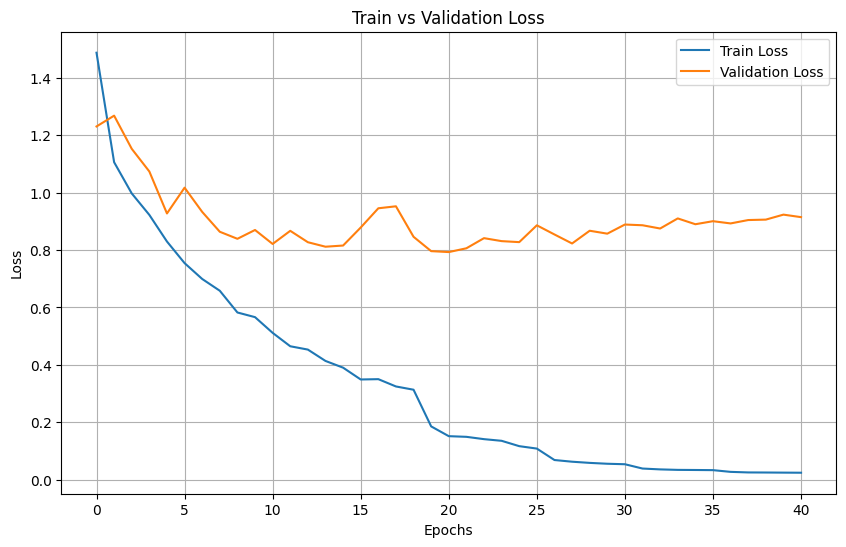

In [27]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Train and Validation Accuracy Plot**

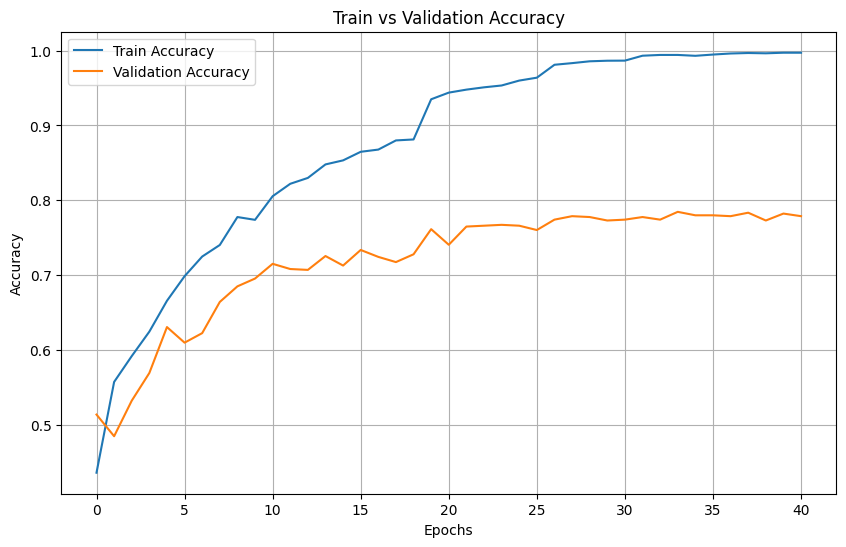

In [28]:
train_acc = history.history['accuracy']  
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation 

### Test data

In [ ]:
test_data = np.load('../artifacts/data_ingestion/Preprocessed Dataset/test_data.npz')

X_test = test_data['arr_0']

y_test = test_data['arr_1']

In [31]:
labelEncodeY = LabelEncoder()

y_test = labelEncodeY.fit_transform(y_test)

y_test = to_categorical(y_test, len(labelEncodeY.classes_))

y_test = np.array(y_test)

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1, batch_size = 16)

print(f"🧪 Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"📉 Test Loss: {test_loss:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 269ms/step - accuracy: 0.7742 - loss: 0.7723
🧪 Test Accuracy: 77.77%
📉 Test Loss: 0.7266


### Train data

In [ ]:
train_data = np.load('../artifacts/data_ingestion/Preprocessed Dataset/train_data.npz')

X_train = train_data['arr_0']

y_train = train_data['arr_1']

In [34]:
labelEncodeY = LabelEncoder()

y_train = labelEncodeY.fit_transform(y_train)

y_train = to_categorical(y_train, len(labelEncodeY.classes_))

y_train = np.array(y_train)

In [37]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1, batch_size = 8)

print(f"🧪 Train Accuracy: {train_accuracy * 100:.2f}%")

print(f"📉 Train Loss: {train_loss:.4f}")

1078/1078 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9329 - loss: 0.2076
🧪 Train Accuracy: 93.55%
📉 Train Loss: 0.2026


### 🏷️ Update MLflow Tracking Configuration for Remote 

In [10]:
MLFlowTracking(model, 224, 3, 32, False, 1000, 10, 'imagenet', 6.2500e-05, 0.0244, 0.9329, 0.7742, 'DenseNet201')

Initialized MLflow to track repo "revanth-kumar-01-ai/360DigitMG-Training-Phase"

Repository revanth-kumar-01-ai/360DigitMG-Training-Phase initialized!

2025/04/22 15:58:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/22 15:58:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'DenseNet201'.
2025/04/22 15:58:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DenseNet201, version 1
Created version '1' of model 'DenseNet201'.


🏃 View run skillful-fox-444 at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0/runs/5c07737f31e84a42a61524e3e32d72a4
🧪 View experiment at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0
✅ MLflow tracking logged successfully! 🚀
